# Linear Regression Assignment

This assignment pertains to building a multiple linear regression model for the prediction of demand for shared bikes. 
BoomBikes a US based bike sharing company wants to understand the demand for shared bikes among the people so that
it can take necessary steps for business growth.

In [1079]:
# Import the required python modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression


import warnings
warnings.filterwarnings('ignore')

## 1. Reading and understanding the dataset

In [1080]:
# read the data from the provided csv
bike = pd.read_csv("day.csv")
bike.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [1081]:
bike.shape

(730, 16)

In [1082]:
bike.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,365.500000,2.498630,0.500000,6.526027,0.028767,2.997260,0.683562,1.394521,20.319259,23.726322,62.765175,12.763620,849.249315,3658.757534,4508.006849
std,210.877136,1.110184,0.500343,3.450215,0.167266,2.006161,0.465405,0.544807,7.506729,8.150308,14.237589,5.195841,686.479875,1559.758728,1936.011647
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,2.000000,20.000000,22.000000
25%,183.250000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.811885,16.889713,52.000000,9.041650,316.250000,2502.250000,3169.750000
50%,365.500000,3.000000,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,20.465826,24.368225,62.625000,12.125325,717.000000,3664.500000,4548.500000
75%,547.750000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.880615,30.445775,72.989575,15.625589,1096.500000,4783.250000,5966.000000
max,730.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,3410.000000,6946.000000,8714.000000


In [1083]:
# Get the info of the dataframe
# It is observed that for each of the data columns there are 730 entries, hence there are no missing values in any
# of the columns, so data imputation is not needed here
bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


In [1084]:
# dropping the data which is not required
# 1. instant: It is index of the data which doesn't aid in modelling
# 2. dteday: There are multiple other columns like year, month, weekday that make this data less relevant
# 3. casual & registerd: Model has to take care of overall bike usage so 'cnt' which is total usage is only relevant and
#    columns can be dropped
bike.drop(['instant', 'dteday', 'casual', 'registered'], axis=1, inplace=True)

In [1085]:
bike.describe()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,2.498630,0.500000,6.526027,0.028767,2.997260,0.683562,1.394521,20.319259,23.726322,62.765175,12.763620,4508.006849
std,1.110184,0.500343,3.450215,0.167266,2.006161,0.465405,0.544807,7.506729,8.150308,14.237589,5.195841,1936.011647
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,22.000000
25%,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.811885,16.889713,52.000000,9.041650,3169.750000
50%,3.000000,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,20.465826,24.368225,62.625000,12.125325,4548.500000
75%,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.880615,30.445775,72.989575,15.625589,5966.000000
max,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,8714.000000


#### Map the numerical values of categorical variables to categorical strings

In [1086]:
# Map the season column to corresponding numerical strings
bike.season = bike.season.map({1:'spring', 2:'summer', 3:'fall', 4:'winter'})

In [1087]:
# Map the Weather situation column to corresponding numerical strings
bike.weathersit = bike.weathersit.map({1:'Clear', 2:'Misty', 3:'Light_Rain_Snow', 4:'Heavy_Rain_Snow'})

In [1088]:
# Map the weekday column to corresponding numerical strings
bike.weekday = bike.weekday.map({0:'Sun',1:'Mon',2:'Tue',3:'Wed',4:'Thu',5:'Fri',6:'Sat'})

In [1089]:
# Map the month column to corresponding numerical strings
bike.mnth = bike.mnth.map({1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'June',7:'July',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'})

In [1090]:
bike.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,spring,0,Jan,0,Sat,0,Misty,14.110847,18.18125,80.5833,10.749882,985
1,spring,0,Jan,0,Sun,0,Misty,14.902598,17.68695,69.6087,16.652113,801
2,spring,0,Jan,0,Mon,1,Clear,8.050924,9.47025,43.7273,16.636703,1349
3,spring,0,Jan,0,Tue,1,Clear,8.200000,10.60610,59.0435,10.739832,1562
4,spring,0,Jan,0,Wed,1,Clear,9.305237,11.46350,43.6957,12.522300,1600


## 2. Perform EDA on the dataset
- This will help to visualize the data and provide an understanding of the dependency between the dependent
  and independent varibles

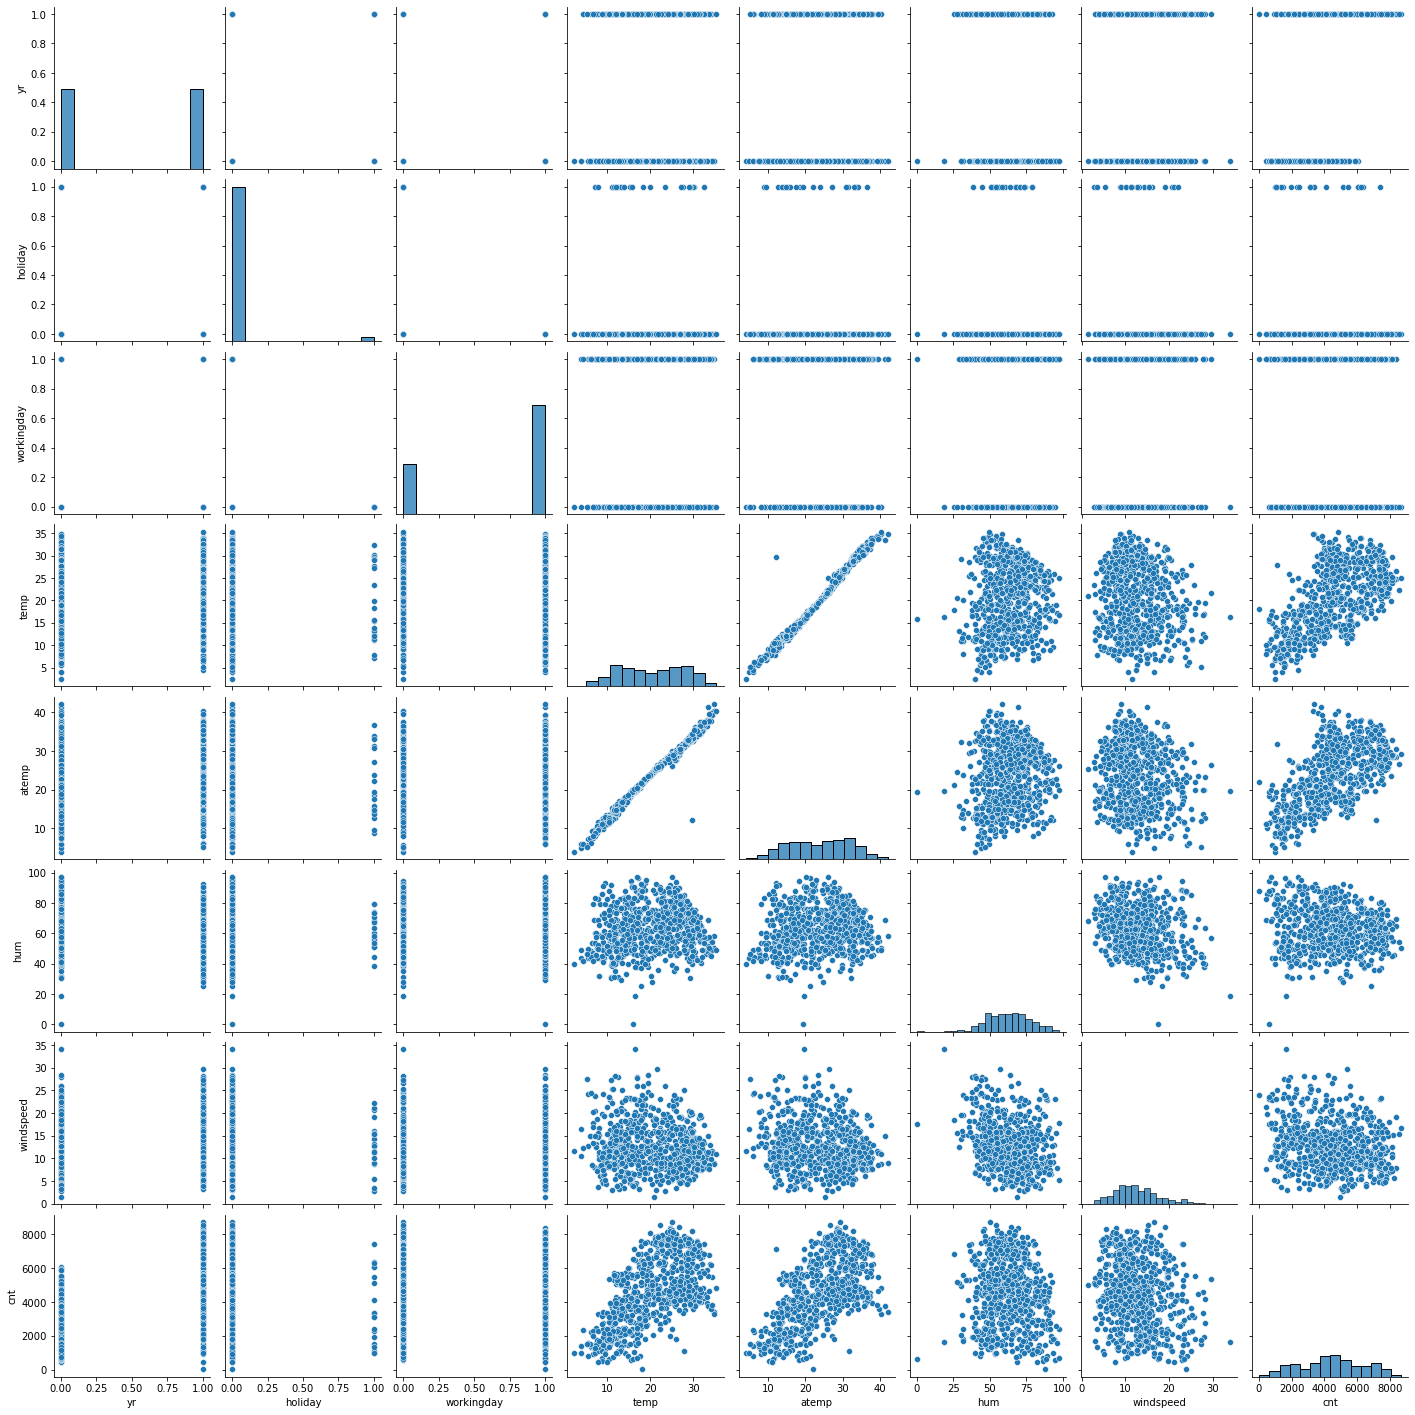

In [1091]:
# Generate the pairplot to get an overall view of data dependency of numerical data
sns.pairplot(bike)
plt.show()

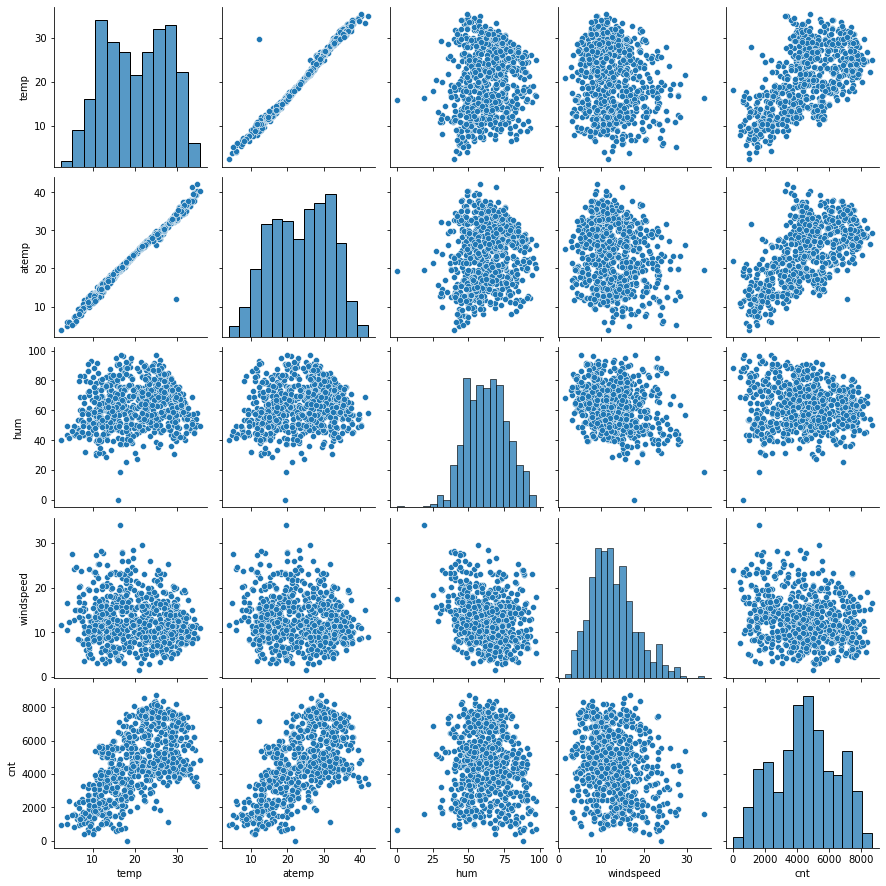

In [1092]:
# The categorical data doesn't throw much light on linear regression phenomenon,
# plotting only the numerical data for better understanding of the data
sns.pairplot(data=bike,vars=['temp','atemp','hum','windspeed','cnt'])
plt.show()

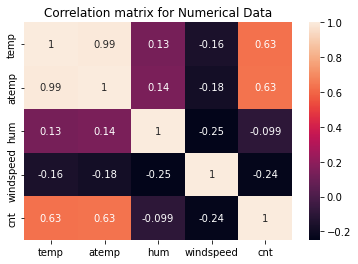

In [1093]:
# In the above pairplot there appears to be a linearly increasing trend between 'cnt vs temp' & 'cnt vs atemp' data. 
# But for 'cnt vs hum' & 'cnt vs windspeed' the data doesn't show signs of positive linearity.
# Generate the correlation matrix with correlation values, this will help to get more insight into the data.

sns.heatmap(bike[['temp','atemp','hum','windspeed','cnt']].corr(), annot = True)
plt.title("Correlation matrix for Numerical Data")
plt.show()

#### As per the above pairplot & heatmap following points can be concluded:
1. There is a positive correlation between 'cnt vs temp' & 'cnt vs atemp'
2. With humidity & windspeed there is a negative correlation
3. temp and atemp are highly correlated and as per the multicolinearity phenomenon either one of these should be used. We will take the decision later as part of modelling

#### Visualise categorical data

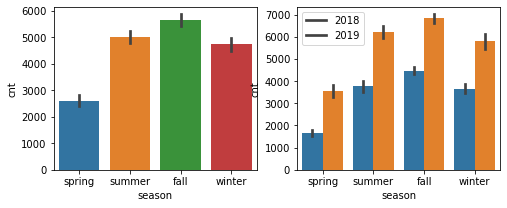

In [1094]:
# Visualization of bike booking in terms of season
# 1. Fall season has highest booking across the 2 years
# 2. Total booking has increased on yearly basis 

plt.figure(figsize = (8,3))
plt.subplot(1,2,1)
sns.barplot('season','cnt',data=bike)
plt.subplot(1,2,2)
sns.barplot('season','cnt',data=bike, hue='yr')
plt.legend(labels=['2018', '2019'])

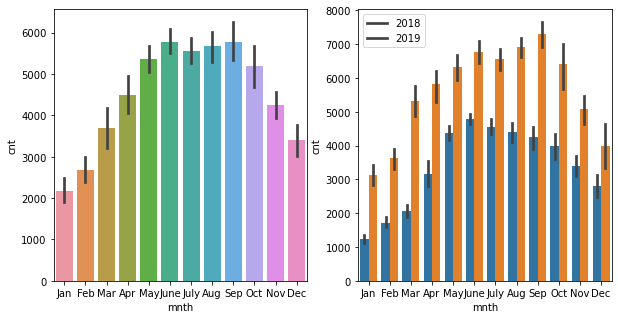

In [1095]:
# Visualization of bike booking in terms of month of a year
# 1. Mid-year period is the time frame when there are max bookings
# 2. There is clear increase in booking on yearly basis per month

plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
sns.barplot('mnth','cnt',data=bike)
plt.subplot(1,2,2)
sns.barplot('mnth','cnt',data=bike, hue='yr')
plt.legend(labels=['2018', '2019'])

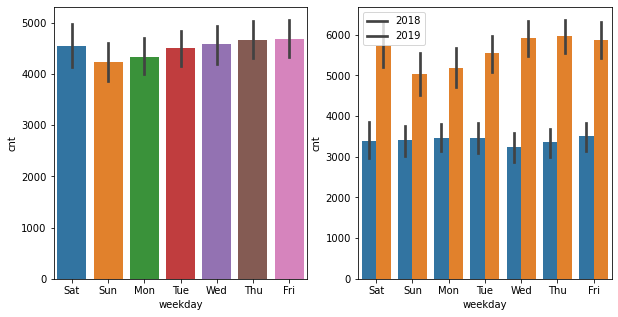

In [1096]:
# Visualization of bike booking in terms of weekdays
# 1. Sunday has lowest booking of all days
# 2. There is clear increase in booking on yearly basis for every day of the week

plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
sns.barplot('weekday','cnt',data=bike)
plt.subplot(1,2,2)
sns.barplot('weekday','cnt',data=bike, hue='yr')
plt.legend(labels=['2018', '2019'])

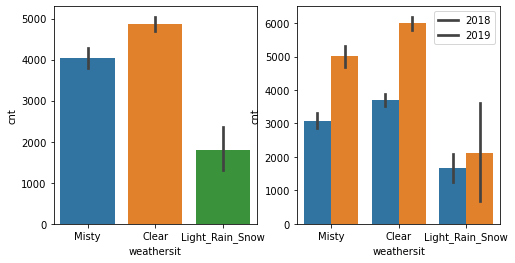

In [1097]:
# Visualization of bike booking in terms of prevailing weather situation
# 1. Clear weather attracted largest booking
# 2. There is clear increase in booking on yearly basis and the rise is high in Misty & Clear weather scenarios

plt.figure(figsize = (8,4))
plt.subplot(1,2,1)
sns.barplot('weathersit','cnt',data=bike)
plt.subplot(1,2,2)
sns.barplot('weathersit','cnt',data=bike, hue='yr')
plt.legend(labels=['2018', '2019'])

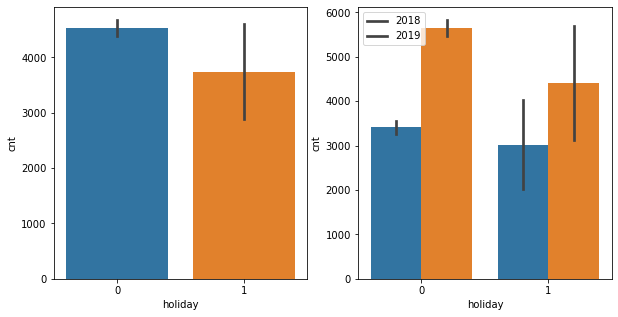

In [1098]:
# Visualization of bike booking in terms of holiday
# 1. Bookings are more during non-holidays  
# 2. There is clear increase in booking on yearly basis here as well

plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
sns.barplot('holiday','cnt',data=bike)
plt.subplot(1,2,2)
sns.barplot('holiday','cnt',data=bike, hue='yr')
plt.legend(labels=['2018', '2019'])

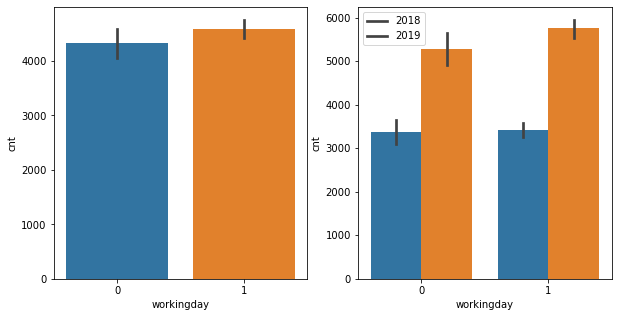

In [1099]:
# Visualization of bike booking in terms of workingday
# 1. Bookings are almost similar for working & non-working days  
# 2. There is clear increase in booking on yearly basis here as well

plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
sns.barplot('workingday','cnt',data=bike)
plt.subplot(1,2,2)
sns.barplot('workingday','cnt',data=bike, hue='yr')
plt.legend(labels=['2018', '2019'])

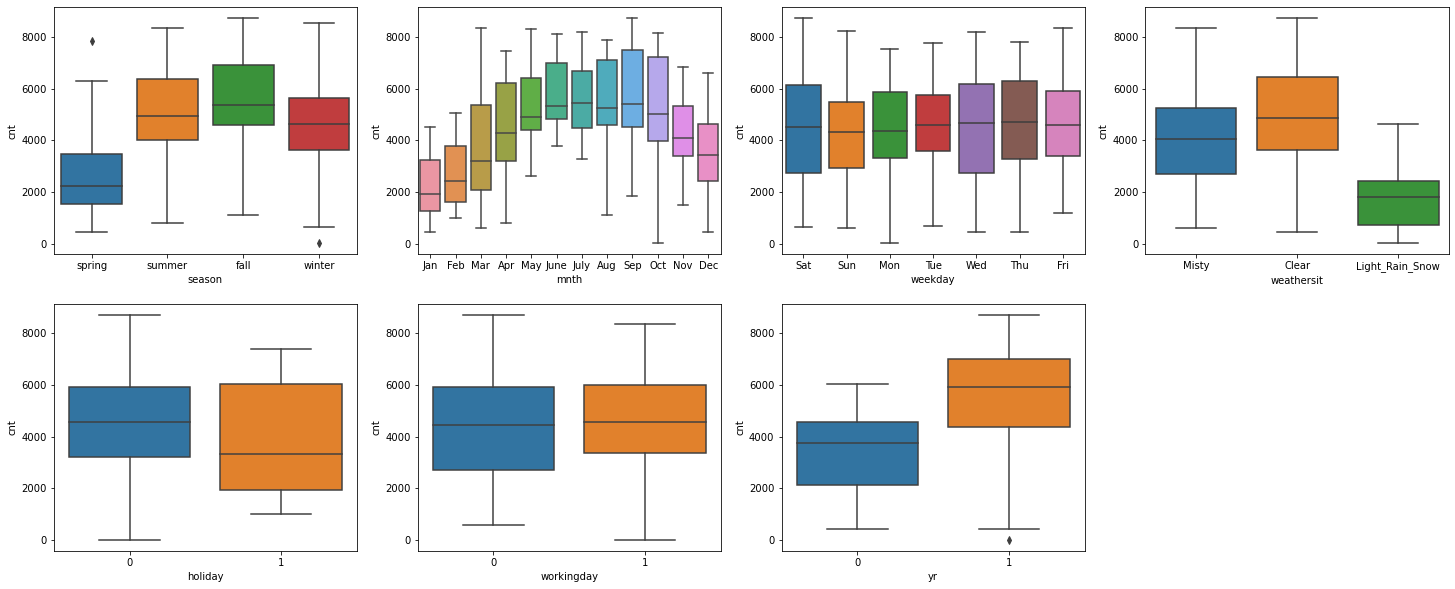

In [1100]:
# Visualization in terms of box-plot
plt.figure(figsize=(25, 10))
plt.subplot(2,4,1)
sns.boxplot(x = 'season', y = 'cnt', data = bike)
plt.subplot(2,4,2)
sns.boxplot(x = 'mnth', y = 'cnt', data = bike)
plt.subplot(2,4,3)
sns.boxplot(x = 'weekday', y = 'cnt', data = bike)
plt.subplot(2,4,4)
sns.boxplot(x = 'weathersit', y = 'cnt', data = bike)
plt.subplot(2,4,5)
sns.boxplot(x = 'holiday', y = 'cnt', data = bike)
plt.subplot(2,4,6)
sns.boxplot(x = 'workingday', y = 'cnt', data = bike)
plt.subplot(2,4,7)
sns.boxplot(x = 'yr', y = 'cnt', data = bike)
plt.show()

# 3. Data Preparation
- Create dummy variables for the categorical data.

In [1101]:
# Create dummy variables for all the non-c ategorical data
mnths_dummy=pd.get_dummies(bike.mnth,drop_first=True)
weekdays_dummy=pd.get_dummies(bike.weekday,drop_first=True)
weathersit_dummy=pd.get_dummies(bike.weathersit,drop_first=True)
season_dummy=pd.get_dummies(bike.season,drop_first=True)

In [1102]:
# Add the dummy variable data to existing dataframe
bike_mod = pd.concat([bike,mnths_dummy,weekdays_dummy,weathersit_dummy,season_dummy],axis=1)

In [1103]:
bike_mod.shape

(730, 34)

In [1104]:
# Drop the columns for which the dummy variables are already created as these are redundant
bike_mod.drop(['mnth','weekday','weathersit','season'], axis = 1, inplace = True)

In [1105]:
# The shape tells us that 4 columns are dropped
bike_mod.shape

(730, 30)

# 4. Splitting the Data into Train and Test Sets

In [1106]:
# Split the data into train and test sets
bike_mod_train, bike_mod_test = train_test_split(bike_mod, train_size = 0.7, random_state = 100)
print(bike_mod_train.shape)
print(bike_mod_test.shape)

(510, 30)
(220, 30)


In [1107]:
# Apply scaling which will aid faster convergence of the algorithms
scaler = MinMaxScaler()
bike_mod_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 510 entries, 576 to 520
Data columns (total 30 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   yr               510 non-null    int64  
 1   holiday          510 non-null    int64  
 2   workingday       510 non-null    int64  
 3   temp             510 non-null    float64
 4   atemp            510 non-null    float64
 5   hum              510 non-null    float64
 6   windspeed        510 non-null    float64
 7   cnt              510 non-null    int64  
 8   Aug              510 non-null    uint8  
 9   Dec              510 non-null    uint8  
 10  Feb              510 non-null    uint8  
 11  Jan              510 non-null    uint8  
 12  July             510 non-null    uint8  
 13  June             510 non-null    uint8  
 14  Mar              510 non-null    uint8  
 15  May              510 non-null    uint8  
 16  Nov              510 non-null    uint8  
 17  Oct           

In [1108]:
# Scale only the numeric variables
num_vars = ['temp','atemp','hum','windspeed','cnt']
bike_mod_train[num_vars] = scaler.fit_transform(bike_mod_train[num_vars])
bike_mod_train.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,Aug,Dec,...,Sat,Sun,Thu,Tue,Wed,Light_Rain_Snow,Misty,spring,summer,winter
576,1,0,1,0.815169,0.766351,0.725633,0.264686,0.827658,0,0,...,0,0,0,1,0,0,0,0,0,0
426,1,0,0,0.442393,0.438975,0.640189,0.255342,0.465255,0,0,...,1,0,0,0,0,0,1,1,0,0
728,1,0,0,0.245101,0.200348,0.498067,0.663106,0.204096,0,1,...,0,1,0,0,0,0,0,1,0,0
482,1,0,0,0.395666,0.391735,0.504508,0.188475,0.482973,0,0,...,1,0,0,0,0,0,1,0,1,0
111,0,0,1,0.345824,0.318819,0.751824,0.380981,0.191095,0,0,...,0,0,0,0,0,0,1,0,1,0


In [1109]:
bike_mod_train.describe()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,Aug,Dec,...,Sat,Sun,Thu,Tue,Wed,Light_Rain_Snow,Misty,spring,summer,winter
count,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,...,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000
mean,0.507843,0.025490,0.676471,0.537440,0.513156,0.650480,0.320883,0.513499,0.096078,0.084314,...,0.154902,0.143137,0.133333,0.131373,0.158824,0.029412,0.345098,0.243137,0.247059,0.247059
std,0.500429,0.157763,0.468282,0.225858,0.212410,0.145846,0.169803,0.224421,0.294988,0.278131,...,0.362166,0.350557,0.340268,0.338139,0.365870,0.169124,0.475867,0.429398,0.431725,0.431725
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.339853,0.332086,0.538643,0.199179,0.356420,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,0.542596,0.529718,0.653714,0.296763,0.518638,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.735215,0.688457,0.754830,0.414447,0.684710,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


###### Here we observe that the min-max value is updated to [0,1] for all the numerical variables after scaling which is inline to the expectation

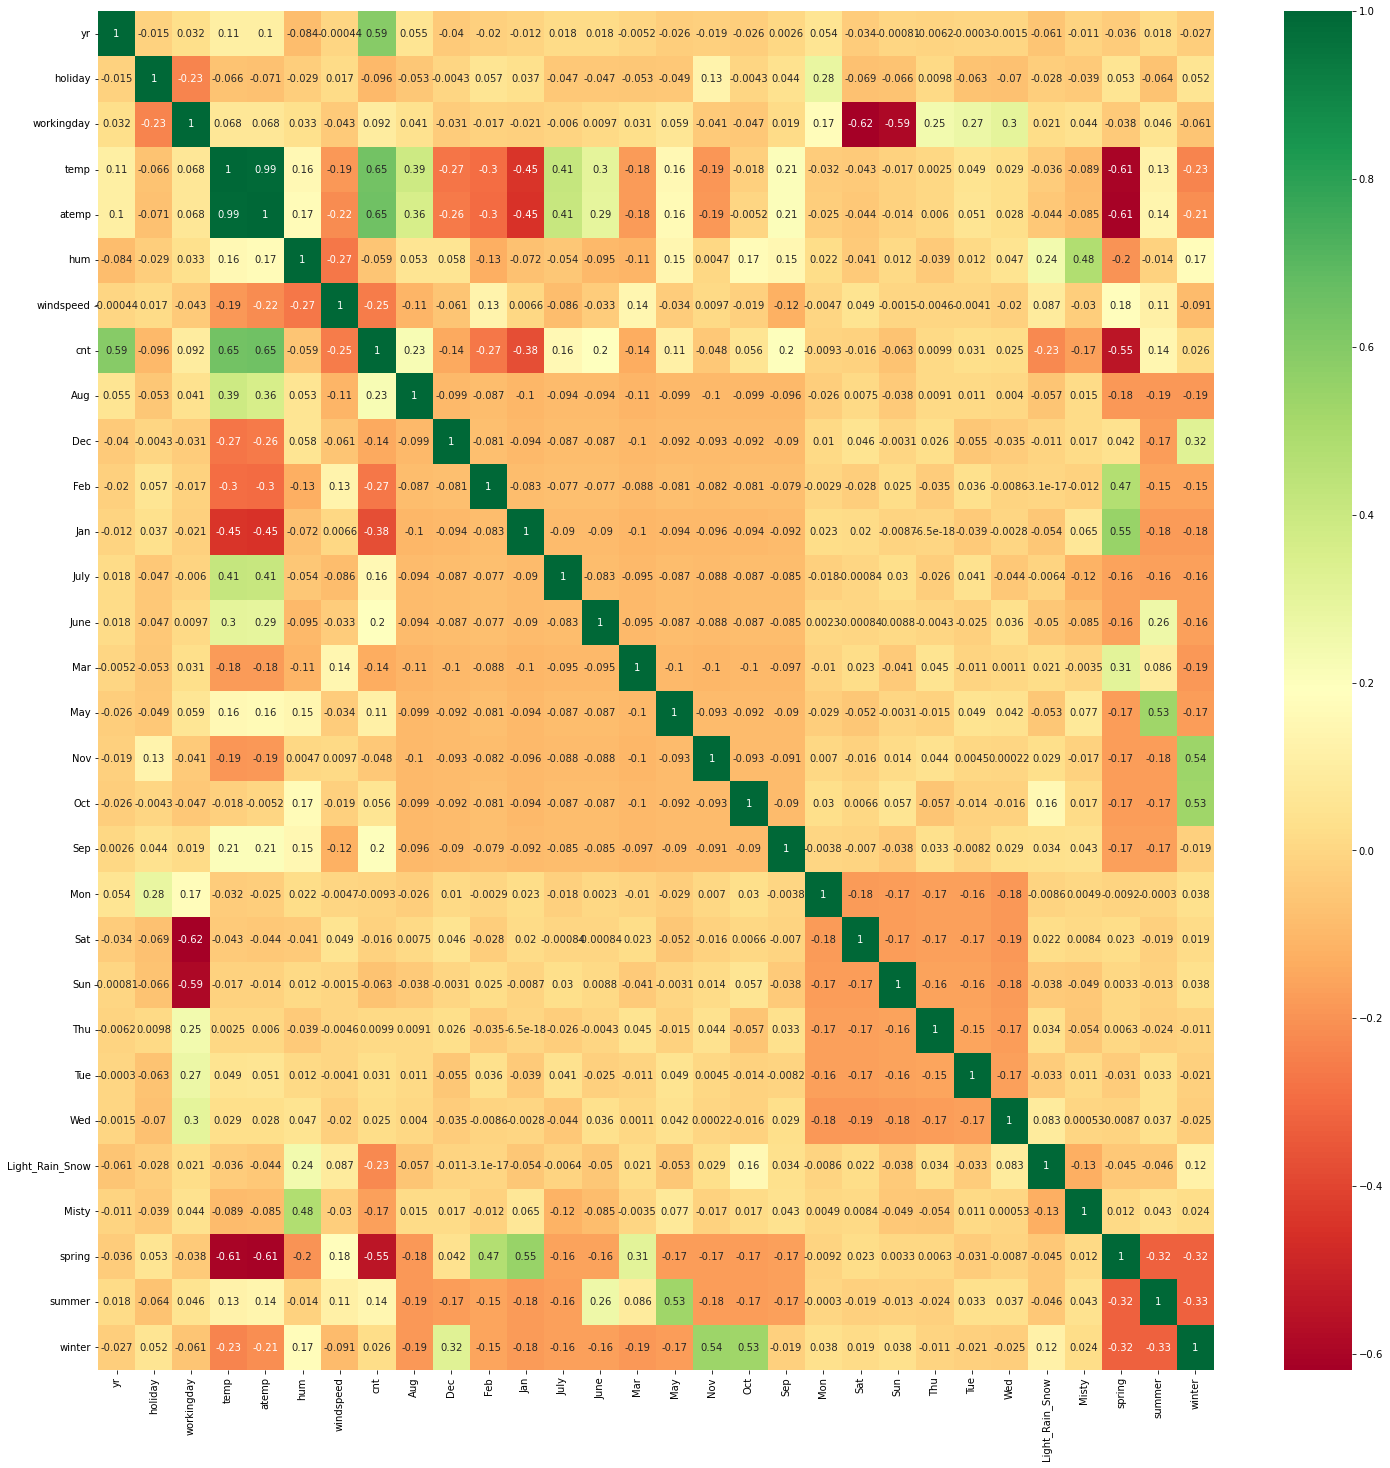

In [1110]:
# Get the correlation between the variables of the model
# To do that plot the heatmap
plt.figure(figsize = (25,25))
sns.heatmap(bike_mod_train.corr(), annot = True, cmap="RdYlGn")
plt.show()

#### cnt and temp are positively correlated

# 5. Build the linear model

In [1111]:
# Building the Linear Model
bike_mod_new = bike_mod_train.copy() 
y_train = bike_mod_new.pop('cnt')
X_train = bike_mod_new

print(y_train.shape)
print(X_train.shape)

(510,)
(510, 29)


In [1112]:
# Using RFE to build the model as there are many predictor variables.
lm = LinearRegression()
lm.fit(X_train, y_train)

# Select the top 15 variables that can have impact on model output
# next step will be to further analyse the model statistically and drop features that are not significant
rfe = RFE(lm, 15)
rfe = rfe.fit(X_train, y_train)

In [1113]:
#List of variables selected in top 15 list
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('yr', True, 1),
 ('holiday', True, 1),
 ('workingday', True, 1),
 ('temp', True, 1),
 ('atemp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('Aug', False, 12),
 ('Dec', False, 4),
 ('Feb', False, 5),
 ('Jan', False, 2),
 ('July', True, 1),
 ('June', False, 14),
 ('Mar', False, 11),
 ('May', False, 6),
 ('Nov', False, 3),
 ('Oct', False, 9),
 ('Sep', True, 1),
 ('Mon', False, 8),
 ('Sat', True, 1),
 ('Sun', True, 1),
 ('Thu', False, 10),
 ('Tue', False, 7),
 ('Wed', False, 13),
 ('Light_Rain_Snow', True, 1),
 ('Misty', True, 1),
 ('spring', True, 1),
 ('summer', False, 15),
 ('winter', True, 1)]

In [1114]:
# select the required column
col = X_train.columns[rfe.support_]
print(col)

Index(['yr', 'holiday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed',
       'July', 'Sep', 'Sat', 'Sun', 'Light_Rain_Snow', 'Misty', 'spring',
       'winter'],
      dtype='object')


In [1115]:
# list of columns that are not important as per RFE
X_train.columns[~rfe.support_]

Index(['Aug', 'Dec', 'Feb', 'Jan', 'June', 'Mar', 'May', 'Nov', 'Oct', 'Mon',
       'Thu', 'Tue', 'Wed', 'summer'],
      dtype='object')

In [1116]:
# dataframe which RFE selected
X_train_rfe = X_train[col]

In [1117]:
# Function to calculate VIF
def calculateVIF(df):
    vif = pd.DataFrame()
    vif['Features'] = df.columns
    vif['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return vif 

In [1118]:
# Building initial linear regression model
# We will build the model in steps analysing following statistics in every step:
# R-squared, adjusted R-squared, p-value, Prob (F-statistic) etc.
X_train_lm_1 = sm.add_constant(X_train_rfe)
lr_1 = sm.OLS(y_train,X_train_lm_1).fit()
print(lr_1.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     190.1
Date:                Wed, 13 Apr 2022   Prob (F-statistic):          8.89e-189
Time:                        16:21:43   Log-Likelihood:                 511.35
No. Observations:                 510   AIC:                            -992.7
Df Residuals:                     495   BIC:                            -929.2
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.2422      0.025     

In [1119]:
# In the summary it observed that the p-value is clearly very high for holiday and so this column can be dropped:
X_train_new = X_train_rfe.drop(['holiday'], axis = 1)

# Get the VIF values after dropping the data
print(calculateVIF(X_train_new))

           Features     VIF
3             atemp  352.34
2              temp  351.00
4               hum   29.43
1        workingday   17.00
5         windspeed    4.65
8               Sat    4.58
9               Sun    4.47
12           spring    2.79
11            Misty    2.28
13           winter    2.16
0                yr    2.08
6              July    1.40
10  Light_Rain_Snow    1.24
7               Sep    1.21


In [1120]:
# In the Regression summary it observed that the p-value is clearly very high 'atemp' and so this column can also be dropped:
X_train_new = X_train_new.drop(['atemp'], axis = 1)

# print the VIF
print(calculateVIF(X_train_new))

# The VIF has dropped significantly so it was right decision to drop this column

           Features    VIF
3               hum  29.19
2              temp  17.25
1        workingday  16.91
7               Sat   4.57
4         windspeed   4.52
8               Sun   4.45
11           spring   2.79
10            Misty   2.28
12           winter   2.14
0                yr   2.08
5              July   1.40
9   Light_Rain_Snow   1.23
6               Sep   1.21


In [1121]:
# Building the 2nd model and analyse statistics 
X_train_lm_2 = sm.add_constant(X_train_new)
lr_2 = sm.OLS(y_train,X_train_lm_2).fit()
print(lr_2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     204.7
Date:                Wed, 13 Apr 2022   Prob (F-statistic):          9.38e-190
Time:                        16:21:43   Log-Likelihood:                 510.91
No. Observations:                 510   AIC:                            -993.8
Df Residuals:                     496   BIC:                            -934.5
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.2355      0.040     

In [1122]:
# VIF of 'hum' column is quite high as per last VIF calculation and so this column can be dropped:
X_train_new = X_train_new.drop(['hum'], axis = 1)
print(calculateVIF(X_train_new))

           Features    VIF
1        workingday  13.12
2              temp  12.38
3         windspeed   4.48
6               Sat   3.77
7               Sun   3.54
10           spring   2.44
0                yr   2.07
11           winter   1.78
9             Misty   1.58
4              July   1.37
5               Sep   1.20
8   Light_Rain_Snow   1.09


In [1123]:
# Building the 3rd model and analyse statistics 
X_train_lm_3 = sm.add_constant(X_train_new)
lr_3 = sm.OLS(y_train,X_train_lm_3).fit()
print(lr_3.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     214.3
Date:                Wed, 13 Apr 2022   Prob (F-statistic):          1.26e-187
Time:                        16:21:44   Log-Likelihood:                 503.06
No. Observations:                 510   AIC:                            -980.1
Df Residuals:                     497   BIC:                            -925.1
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1553      0.035     

In [1124]:
# VIF of 'workingday' column is quite high as per last calculation and so this column can be dropped:
X_train_new = X_train_new.drop(['workingday'], axis = 1)
print(calculateVIF(X_train_new))

           Features   VIF
1              temp  4.72
2         windspeed  4.04
0                yr  2.06
9            spring  1.66
8             Misty  1.52
10           winter  1.41
3              July  1.35
5               Sat  1.22
6               Sun  1.21
4               Sep  1.20
7   Light_Rain_Snow  1.08


In [1125]:
# Building the 4th model and analyse statistics 
X_train_lm_4 = sm.add_constant(X_train_new)
lr_4 = sm.OLS(y_train,X_train_lm_4).fit()
print(lr_4.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     225.6
Date:                Wed, 13 Apr 2022   Prob (F-statistic):          1.84e-185
Time:                        16:21:44   Log-Likelihood:                 495.11
No. Observations:                 510   AIC:                            -966.2
Df Residuals:                     498   BIC:                            -915.4
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.2558      0.024     

In [1126]:
# In the summary it observed that the p-value is clearly very high for 'Sat' column and so this column can be dropped:
X_train_new = X_train_new.drop(['Sat'], axis = 1)
print(calculateVIF(X_train_new))

          Features   VIF
1             temp  4.67
2        windspeed  4.00
0               yr  2.06
8           spring  1.64
7            Misty  1.52
9           winter  1.40
3             July  1.35
4              Sep  1.20
5              Sun  1.17
6  Light_Rain_Snow  1.08


In [1127]:
# Building the 5th model and analyse statistics 
X_train_lm_5 = sm.add_constant(X_train_new)
lr_5 = sm.OLS(y_train,X_train_lm_5).fit()
print(lr_5.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     247.6
Date:                Wed, 13 Apr 2022   Prob (F-statistic):          2.75e-186
Time:                        16:21:44   Log-Likelihood:                 494.20
No. Observations:                 510   AIC:                            -966.4
Df Residuals:                     499   BIC:                            -919.8
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.2586      0.024     

#### Model appears to good as it fulfills the following factors:
- VIF value of the model is below 5
- p value of all the predictor varaibles is almost 0 so all the coefficients are significant
- r-squared value is 0.832
- probability of Prob (F-statistic) is almost 0

# 6. Residual Analysis of the train data and validation

In [1128]:
y_train_pred = lr_5.predict(X_train_lm_5)
y_train_pred

576    0.752323
426    0.461566
728    0.350746
482    0.564694
111    0.280573
         ...   
578    0.854973
53     0.219231
350    0.273377
79     0.312071
520    0.632471
Length: 510, dtype: float64

Text(0.5, 0, 'Errors')

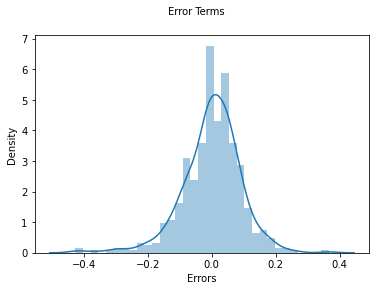

In [1129]:
# Plot the histogram of the residual data
fig = plt.figure()
sns.distplot(y_train - y_train_pred)
fig.suptitle('Error Terms', fontsize = 10) 
plt.xlabel('Errors', fontsize = 10)

##### Residual data follows the expected normal distribution

#### Check for Homoscedasticity

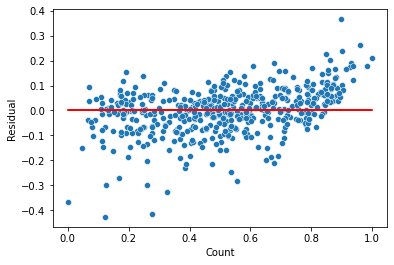

In [1130]:
residual = y_train - y_train_pred
sns.scatterplot(y_train,residual)
plt.plot(y_train,[0]*len(y_train), '-r')
plt.xlabel('Count')
plt.ylabel('Residual')
plt.show()

##### Most of the residual data points appear to have a constant deviation from zero line leaving aside a few outliers

# 7. Prediction and evaluation of data

In [1131]:
# Scale only the numeric variables
num_vars = ['temp','atemp','hum','windspeed','cnt']
bike_mod_test[num_vars] = scaler.fit_transform(bike_mod_test[num_vars])
bike_mod_test.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,Aug,Dec,...,Sat,Sun,Thu,Tue,Wed,Light_Rain_Snow,Misty,spring,summer,winter
184,0,1,0,0.837241,0.778767,0.534223,0.149393,0.704300,0,0,...,0,0,0,0,0,0,1,0,0,0
535,1,0,1,0.911423,0.855132,0.470417,0.231142,0.725421,0,0,...,0,0,0,0,1,0,0,0,1,0
299,0,0,1,0.496221,0.492359,0.777843,0.443398,0.278853,0,0,...,0,0,1,0,0,0,1,0,0,1
221,0,0,1,0.890387,0.805661,0.236659,0.449707,0.545512,1,0,...,0,0,0,0,1,0,0,0,0,0
152,0,0,1,0.821739,0.749249,0.070765,0.682387,0.569148,0,0,...,0,0,1,0,0,0,0,0,1,0


In [1132]:
y_test = bike_mod_test.pop('cnt')
X_test = bike_mod_test

In [1133]:
# Get the columns that are relvany as per the last dataframe
col1 = X_train_new.columns

X_test = X_test[col1]

# Adding constant variable to test dataframe
X_test_lm = sm.add_constant(X_test)
y_pred = lr_5.predict(X_test_lm)
r2 = r2_score(y_true=y_test, y_pred=y_pred)
round(r2,4)

0.7969

# Model evaluation

In [1134]:
round(lr_5.params,4)

const              0.2586
yr                 0.2346
temp               0.4493
windspeed         -0.1410
July              -0.0698
Sep                0.0522
Sun               -0.0443
Light_Rain_Snow   -0.2859
Misty             -0.0797
spring            -0.1147
winter             0.0438
dtype: float64

In [1135]:
# Model can be represneted in the form of following equation:
# cnt = 0.2586 + 0.2346*yr + 0.4493*temp - 0.1410*windspeed - 0.0698*July + 0.0522*Sep - 0.0443*Sun - 0.2859*Light_Rain_Snow - 0.0797*Misty - 0.1147*spring + 0.0438*winter

In [1136]:
# Adjusted-R^2 value calculation
adjusted_r2 = round(1-(1-r2)*(X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1),4)
print(adjusted_r2)

0.7871


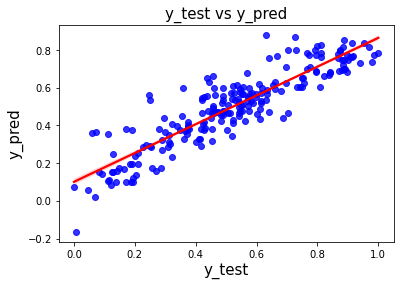

In [1137]:
# Visualizing the fit on the test data
# plotting a Regression plot

plt.figure()
sns.regplot(x=y_test, y=y_pred, ci=68, fit_reg=True,scatter_kws={"color": "blue"}, line_kws={"color": "red"})
plt.title('y_test vs y_pred', fontsize=15)
plt.xlabel('y_test', fontsize=15)
plt.ylabel('y_pred', fontsize=15)
plt.show()

Comparision between Training and Testing dataset:
- Train dataset R^2          : 0.832
- Test dataset R^2           : 0.7969
- Train dataset Adjusted R^2 : 0.829    
- Test dataset Adjusted R^2  : 0.7871